# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, -1])
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
0,10,-4.999507,1.0,6.0,12.0,0.9,0.11,0.1
1,14,-7.171885,1.0,6.0,12.0,0.9,0.11,0.1
2,19,-9.277114,1.0,6.0,12.0,0.9,0.11,0.1
3,23,-10.143018,1.0,6.0,12.0,0.9,0.11,0.1
4,28,-10.149250,1.0,6.0,12.0,0.9,0.11,0.1


In [3]:
# data1 = create_ratio(data, True)
# data2 = create_spatial_intensity(data)
# sim_params = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Fetal Hb Concentration", "Fetal Saturation", "Maternal Saturation"]
# data = pd.merge(data1, data2, how='inner', on=sim_params)

# data = create_ratio(data, True)

data = create_spatial_intensity(data)

data.head() 
# NOTE: Have only 1 on at the same time!

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-4.784362,-5.887022,-6.560915,-7.015157,-7.712442,...,-19.639869,-22.003357,-25.265887,-28.112349,-31.952534,-35.240710,-39.608559,-43.300212,-48.150422,-52.211376
1,2.0,12.0,0.9,0.11,0.225,-4.783804,-5.882596,-6.550246,-6.998650,-7.687817,...,-19.677858,-22.046210,-25.314961,-28.166499,-32.013139,-35.306559,-39.681050,-43.378082,-48.235089,-52.301534
2,2.0,12.0,0.9,0.11,0.350,-4.783210,-5.877882,-6.538860,-6.980969,-7.661314,...,-19.715011,-22.088109,-25.362928,-28.219417,-32.072350,-35.370881,-39.751845,-43.454117,-48.317744,-52.389537
3,2.0,12.0,0.9,0.11,0.475,-4.782576,-5.872834,-6.526638,-6.961915,-7.632599,...,-19.751362,-22.129094,-25.409836,-28.271155,-32.130227,-35.433740,-39.821015,-43.528395,-48.398473,-52.475475
4,2.0,12.0,0.9,0.11,0.600,-4.781896,-5.867394,-6.513429,-6.941227,-7.601231,...,-19.786945,-22.169203,-25.455727,-28.321760,-32.186822,-35.495197,-39.888626,-43.600986,-48.477353,-52.559433


In [4]:
# Cleanup
data.dropna(inplace=True)
data.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-4.784362,-5.887022,-6.560915,-7.015157,-7.712442,...,-19.639869,-22.003357,-25.265887,-28.112349,-31.952534,-35.240710,-39.608559,-43.300212,-48.150422,-52.211376
1,2.0,12.0,0.9,0.11,0.225,-4.783804,-5.882596,-6.550246,-6.998650,-7.687817,...,-19.677858,-22.046210,-25.314961,-28.166499,-32.013139,-35.306559,-39.681050,-43.378082,-48.235089,-52.301534
2,2.0,12.0,0.9,0.11,0.350,-4.783210,-5.877882,-6.538860,-6.980969,-7.661314,...,-19.715011,-22.088109,-25.362928,-28.219417,-32.072350,-35.370881,-39.751845,-43.454117,-48.317744,-52.389537
3,2.0,12.0,0.9,0.11,0.475,-4.782576,-5.872834,-6.526638,-6.961915,-7.632599,...,-19.751362,-22.129094,-25.409836,-28.271155,-32.130227,-35.433740,-39.821015,-43.528395,-48.398473,-52.475475
4,2.0,12.0,0.9,0.11,0.600,-4.781896,-5.867394,-6.513429,-6.941227,-7.601231,...,-19.786945,-22.169203,-25.455727,-28.321760,-32.186822,-35.495197,-39.888626,-43.600986,-48.477353,-52.559433


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [5]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
y_columns = ['Fetal Saturation']
# y_columns = ['Fetal Hb Concentration']

## X -> Predictors
# x_columns = list(filter(lambda X: '_' in X, data.columns))
# x_columns = list(filter(lambda X: X.isdigit(), data.columns))
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))



## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])
## Manual scale - if needed (With maternal info.)
# data[x_columns[:-2]] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
# data[x_columns[:-2]] += 0.5  # unit var, 0 mean

## Scale non-intensity x columns (Maternal Hb Conc. , Maternal Saturation)
# data["Maternal Saturation"] -= 0.5 
# data["Maternal Hb Concentration"] /= 20
# data["Maternal Hb Concentration"] -= 0.5 


In [6]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [0.35]
Y scale var [0.03125]


In [7]:
data[y_columns].value_counts()

Fetal Saturation
-1.414214           375
-0.707107           375
 0.000000           375
 0.707107           375
 1.414214           375
dtype: int64

## Model Configuration

In [8]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)
model_config = {
    # 'model_class' : SplitChannelCNN,  # Class name
    'model_class' : PerceptronReLU,  # Class name
    # 'model_params' :  [2, IN_FEATURES, 4, 5, [2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 5, [6, 3, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 7, [3, OUT_FEATURES]],    # Input params as an array
    'model_params' :  [[IN_FEATURES, 8, OUT_FEATURES]],    # Input params as an array
    'train_split' : 0.8,
    'epochs' : 100,
}

In [9]:
# Custom Train Function 
def train_model2(iteration_config, epoch=60):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [10]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.93, 0.95, 0.97]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=40, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=80, resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


2023-07-13 16:43:05,617	INFO worker.py:1625 -- Started a local Ray instance.
2023-07-13 16:43:06,429	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


== Status ==
Current time: 2023-07-13 16:43:06 (running for 00:00:00.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-13_16-43-06
Number of trials: 70/80 (69 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |
|--------------------------+----------+-----------------------+--------------+-------------+------------|
| train_model2_0408b_00000 | RUNNING  | 169.237.32.34:1979683 |           32 | 0.000146061 |       0.95 |
| train_model2_0408b_00001 | PENDING  |                       |           32 | 0.00069938  |       0.97 |
| train_model2_0408b_00002 | PENDING  |                       |          

Trial name,combined_loss,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_0408b_00000,0.8953,2023-07-13_16-43-32,True,blueberry,40,169.237.32.34,1979683,24.7093,0.569685,24.7093,1689291812,0.952443,40,0408b_00000,0.940004
train_model2_0408b_00001,0.125466,2023-07-13_16-43-35,True,blueberry,40,169.237.32.34,1979768,25.6521,0.521393,25.6521,1689291815,0.367839,40,0408b_00001,0.341089
train_model2_0408b_00002,0.168995,2023-07-13_16-43-59,False,blueberry,35,169.237.32.34,1979770,49.327,1.26195,49.327,1689291839,0.356825,35,0408b_00002,0.473607
train_model2_0408b_00003,1.05354,2023-07-13_16-43-17,True,blueberry,5,169.237.32.34,1979772,7.73813,0.796715,7.73813,1689291797,1.04288,5,0408b_00003,1.01022
train_model2_0408b_00004,0.110634,2023-07-13_16-43-58,False,blueberry,35,169.237.32.34,1979774,48.8197,1.35355,48.8197,1689291838,0.330881,35,0408b_00004,0.334362
train_model2_0408b_00005,0.952889,2023-07-13_16-43-19,True,blueberry,10,169.237.32.34,1979778,9.86018,0.549007,9.86018,1689291799,0.980184,10,0408b_00005,0.972153
train_model2_0408b_00006,1.01576,2023-07-13_16-43-16,True,blueberry,5,169.237.32.34,1979781,6.48178,0.746317,6.48178,1689291796,1.02047,5,0408b_00006,0.995386
train_model2_0408b_00007,0.954204,2023-07-13_16-43-21,True,blueberry,10,169.237.32.34,1979789,11.7347,0.84831,11.7347,1689291801,0.979024,10,0408b_00007,0.974648
train_model2_0408b_00008,0.998023,2023-07-13_16-43-22,True,blueberry,10,169.237.32.34,1979791,12.5172,0.69904,12.5172,1689291802,0.998499,10,0408b_00008,0.999524
train_model2_0408b_00009,0.969595,2023-07-13_16-43-22,True,blueberry,10,169.237.32.34,1979793,12.1876,0.857136,12.1876,1689291802,0.986315,10,0408b_00009,0.983048


== Status ==
Current time: 2023-07-13 16:43:11 (running for 00:00:05.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-13_16-43-06
Number of trials: 80/80 (64 PENDING, 16 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_0408b_00000 | RUNNING  | 169.237.32.34:1979683 

2023-07-13 16:44:00,766	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2023-07-13 16:44:00 (running for 00:00:54.34)
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 40.000: -0.5103827479672621 | Iter 20.000: -0.46915230942980907 | Iter 10.000: -0.9408175096787739 | Iter 5.000: -0.9903370493466506
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-13_16-43-06
Number of trials: 80/80 (28 PENDING, 16 RUNNING, 36 TERMINATED)
+--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+---

2023-07-13 16:44:02,438	ERROR tune.py:941 -- Trials did not complete: [train_model2_0408b_00002, train_model2_0408b_00004, train_model2_0408b_00027, train_model2_0408b_00029, train_model2_0408b_00032, train_model2_0408b_00034, train_model2_0408b_00037, train_model2_0408b_00041, train_model2_0408b_00044, train_model2_0408b_00045, train_model2_0408b_00046, train_model2_0408b_00047, train_model2_0408b_00048, train_model2_0408b_00049, train_model2_0408b_00050, train_model2_0408b_00051, train_model2_0408b_00052, train_model2_0408b_00053, train_model2_0408b_00054, train_model2_0408b_00055, train_model2_0408b_00056, train_model2_0408b_00057, train_model2_0408b_00058, train_model2_0408b_00059, train_model2_0408b_00060, train_model2_0408b_00061, train_model2_0408b_00062, train_model2_0408b_00063, train_model2_0408b_00064, train_model2_0408b_00065, train_model2_0408b_00066, train_model2_0408b_00067, train_model2_0408b_00068, train_model2_0408b_00069, train_model2_0408b_00070, train_model2_0408b_

Best trial config: {'lr': 0.0008556672516510563, 'batch_size': 8, 'momentum': 0.95}
Best trial final validation loss: 0.2605669306630784
Best trial final train loss: 0.31563655077975167


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [ ]:
best_trial.config

{'lr': 0.0002887067743586193, 'batch_size': 8, 'momentum': 0.97}

In [ ]:
model_config

{'model_class': inverse_modelling_tfo.models.custom_models.PerceptronReLU,
 'model_params': [[40, 8, 1]],
 'train_split': 0.8,
 'epochs': 100}

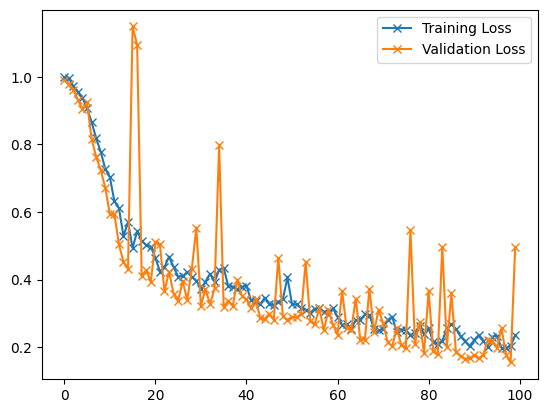

In [ ]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': 8, 'shuffle': True, 'num_workers': 2
}
params['batch_size'] = best_trial.config['batch_size']
train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
model = model_config['model_class'](*model_config['model_params'])
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
# optimizer = SGD(model.parameters(), lr=0.0004, momentum=0.9)
optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
# train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=150, gpu_to_use=0)
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=model_config['epochs'], gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [ ]:
print(f'Train MSE : {train_loss[-1]}, Val MSE : {validation_loss[-1]}')

Train MSE : 0.23459347065022967, Val MSE : 0.495983786088355


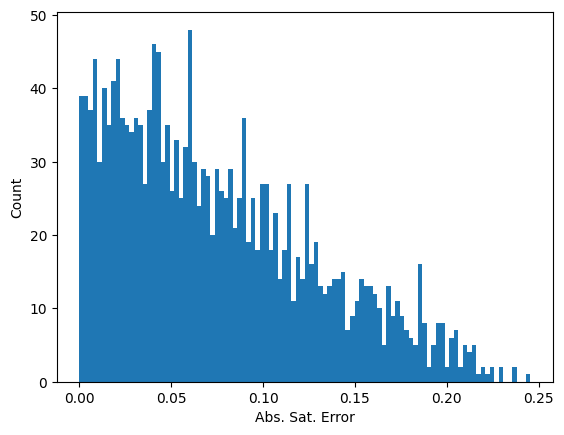

In [ ]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error})
plt.figure()
error_df['%tage'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel('Abs. Sat. Error')
plt.ylabel('Count')
plt.show()

In [ ]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
combined_table = data.join(error_df)
with pd.option_context("display.max_rows", None):
    display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Truth,Predicted,Absolute Error,%tage
1225,4.0,16.0,1.000,0.110,-1.414214,0.100,0.345457,0.245457,0.245457
1200,4.0,16.0,0.975,0.110,-1.414214,0.100,0.337316,0.237316,0.237316
1075,4.0,15.0,0.975,0.110,-1.414214,0.100,0.336935,0.236935,0.236935
1100,4.0,15.0,1.000,0.110,-1.414214,0.100,0.330710,0.230710,0.230710
1050,4.0,15.0,0.950,0.110,-1.414214,0.100,0.329999,0.229999,0.229999
249,2.0,13.0,1.000,0.170,1.414214,0.600,0.375483,0.224517,0.224517
925,4.0,14.0,0.950,0.110,-1.414214,0.100,0.323926,0.223926,0.223926
124,2.0,12.0,1.000,0.170,1.414214,0.600,0.376748,0.223252,0.223252
900,4.0,14.0,0.925,0.110,-1.414214,0.100,0.319640,0.219640,0.219640
224,2.0,13.0,0.975,0.170,1.414214,0.600,0.381194,0.218806,0.218806


In [ ]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.00733105]
Validation Error(non-normalized): [0.01549949]


In [ ]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PerceptronReLU                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       328
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       9
│    └─Flatten: 2-4                      --
Total params: 337
Trainable params: 337
Non-trainable params: 0

In [ ]:
error_df.columns

Index(['Truth', 'Predicted', 'Absolute Error', '%tage'], dtype='object')